In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
from sklearn.metrics import *
import tensorflow.keras.backend as K
import os
# import tempfile
import warnings
warnings.filterwarnings("ignore")
import seaborn as sr
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import *

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tqdm import tqdm

from Custom_Image_generator import *
# from neural_net import build_model,build_and_train
# from customized_data_generator import CustomDataGen
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


2022-12-08 11:18:21.755883: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Base Model

In [2]:
model_path = "/media/kashraf/Elements/Dissertation/modelling/hyperopt/Wavelet_based/theta/weights"
base_model = load_model(os.path.join(model_path,"f606b_theta_interv1_V1.h5"),custom_objects={"tf":tf})
base_model.summary()

2022-12-08 11:18:22.846815: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-08 11:18:22.847917: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-08 11:18:22.984639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 11:18:22.985062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-08 11:18:22.985120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-08 11:18:22.988555: I tensorflow/stream_executor/platfor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 148, 148, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 148, 148, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 148, 51) 20451       conv2d[0][0]                     
______________________________________________________________________________________________

In [3]:
# base_model.layers[:-17]

In [4]:
for layer in base_model.layers[:-17]:
    layer.trainable = False
x = base_model.layers[-7].output
x = Flatten()(x)
base_model = Model(inputs=base_model.input, outputs=x)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 148, 148, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 148, 148, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 148, 51) 20451       conv2d[0][0]                     
______________________________________________________________________________________________

In [5]:
def create_base(shape):
    inputs=Input(shape=shape)
    
    # First conv layer
    x = Conv2D(64, (7, 7), padding="same",kernel_regularizer=l2(0.01))(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    
     # Second conv layer
    x = Conv2D(124, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(256, (5,5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   
    
    x = Conv2D(512, (5, 5), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    
    x = Conv2D(512, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(512, (3, 3), padding="same",kernel_regularizer=l2(0.01))(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    
    x = pca()(x)
    outputs= Flatten()(x)
    return Model(inputs, outputs)


### Base model from hyper_space

In [6]:

# path= "/media/kashraf/Elements/Dissertation/modelling/hyperopt/intervals/stacked/interv1/weights"
# model1= load_model(os.path.join(path,"8986c_stacked_interv1_V1.h5"))
# base_model = Model(inputs=model1.input,outputs=model1.get_layer("dropout_1").output)
# base_model = Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.01))(base_model)
# base_model.summary()

In [7]:
# model1.summary()

In [8]:
def get_img_label(path,interval,keyword="train"):
    paths = []
    cl2_files = os.listdir ( os.path.join(path, "interv"+str(interval),keyword,"cl2"))
    cl2_files = [os.path.join(path, "interv"+str(interval),keyword,"cl2",file) 
               for file in cl2_files]
    
    cl4_files = os.listdir ( os.path.join(path, "interv"+str(interval),
                                          keyword,"cl4"))
    cl4_files = [os.path.join(path, "interv"+str(interval),
                        keyword,"cl4",file) for file in cl4_files]

    cl6_files = os.listdir ( os.path.join(path, "interv"+str(interval),
                                          keyword,"cl6"))
    cl6_files = [os.path.join(path, "interv"+str(interval),keyword,"cl6",
                              file) for file in cl6_files]
    
  
    cl8_files = os.listdir ( os.path.join(path, 
                                "interv"+str(interval),keyword,"cl8"))
    cl8_files = [os.path.join(path, 
        "interv"+str(interval),keyword,"cl8",file) for file in cl8_files]
    
    int_files = [cl2_files,cl4_files,cl6_files,cl8_files]
    
    paths +=int_files
    
    labels = [[0]*len(cl2_files),[1]*len(cl4_files),
            [2]*len(cl6_files),[3]*len(cl8_files)]
    
 
    return np.concatenate(paths),np.concatenate(labels)

In [9]:
# path = "/media/kashraf/Elements/Dissertation/data/pouya_topomaps/beta/"
path = "/media/kashraf/Elements/Dissertation/data/preprocessed/audio/alpha/"
os.listdir(path)

['interv1', 'interv2', 'interv3', 'interv4', 'interv5', 'interv6', 'interv7']

## Custom data generator

In [10]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, x_fnames,y_fnames,batch_size,target_size=(148, 148, 3),shuffle=True):
        
        self.x_fnames = x_fnames
        self.y_fnames = y_fnames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()
       
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.x_fnames[0].shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __process_batch(self,batch_files):
        interval_images = []
        for file in batch_files:
            image = tf.keras.preprocessing.image.load_img(file)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr,(self.target_size[0], self.target_size[1])).numpy()
            interval_images.append(image_arr/255)
        return interval_images
  
    
    def __get_data(self,batch_indexes):
        
        files = self.x_fnames
        
        # Select batch files and labels from all files 
        batch_files = [file[batch_indexes] for file in files] 
        
        batch_images = [np.array(self.__process_batch (batch)) 
                        for batch in batch_files]
        
        batch_labels = self.y_fnames[batch_indexes]
        batch_labels = to_categorical(batch_labels,num_classes=4)
        
        return batch_images,batch_labels

    
    def __getitem__(self, index):
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        x, y = self.__get_data(indexes)        
        return x, y
    
    def __len__(self):
        return int(np.floor(self.x_fnames[0].shape[0]) / self.batch_size)


In [11]:
x_train_files = [get_img_label (path, interv,keyword="train")[0] for interv in range(1,8)]
y_train_files = get_img_label (path,1,keyword="train")[1]

x_test_files = [get_img_label (path, interv,keyword="test")[0] for interv in range(1,8)]
y_test_files =get_img_label (path,1,keyword="test")[1]

train_gen = CustomDataGen(x_train_files,y_train_files,batch_size=8)
test_gen  = CustomDataGen(x_test_files,y_test_files,batch_size=8)


In [12]:
# test_gen.x_fnames

### PCA layer

In [13]:
class pca(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        
        m, p, q, n = X.shape
        X_r = tf.transpose(X, perm=[0,3,1,2])
        X_r = tf.reshape(X_r, (-1, p, q))
        if m != None:
            i=0
            if self.g is None:
                self.g = tf.Variable(tf.zeros((m*n, p, self.n_components)))
            
            for x in X_r:
                
                cov = tf.tensordot(x, x, axes=1)
                s, u, v = tf.linalg.svd(cov)
                U1 = u[:, 0:self.n_components]

                x_proj = tf.tensordot(x, U1, axes=1)
                
                self.g[i].assign(x_proj)
                i += 1
            return tf.reshape(self.g, (m, -1, n))
        
        return X[:, :, 0, :]
class pca_mean(Layer):
    def __init__(self, n_components = 1):
        super().__init__()
        self.g = None
        self.n_components = n_components
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'g': self.g,
            'n_components': self.n_components
        })
        return config
    
    @tf.function
    def call(self, X):
        m, p, q, n = X.shape
        if m != None:
            i=0
            if self.g is None:
                pca_layer = pca()
                
                self.g = pca_layer(X)
                return tf.reduce_mean(self.g, axis=1)
        
        return X[:, 0, 0, :]

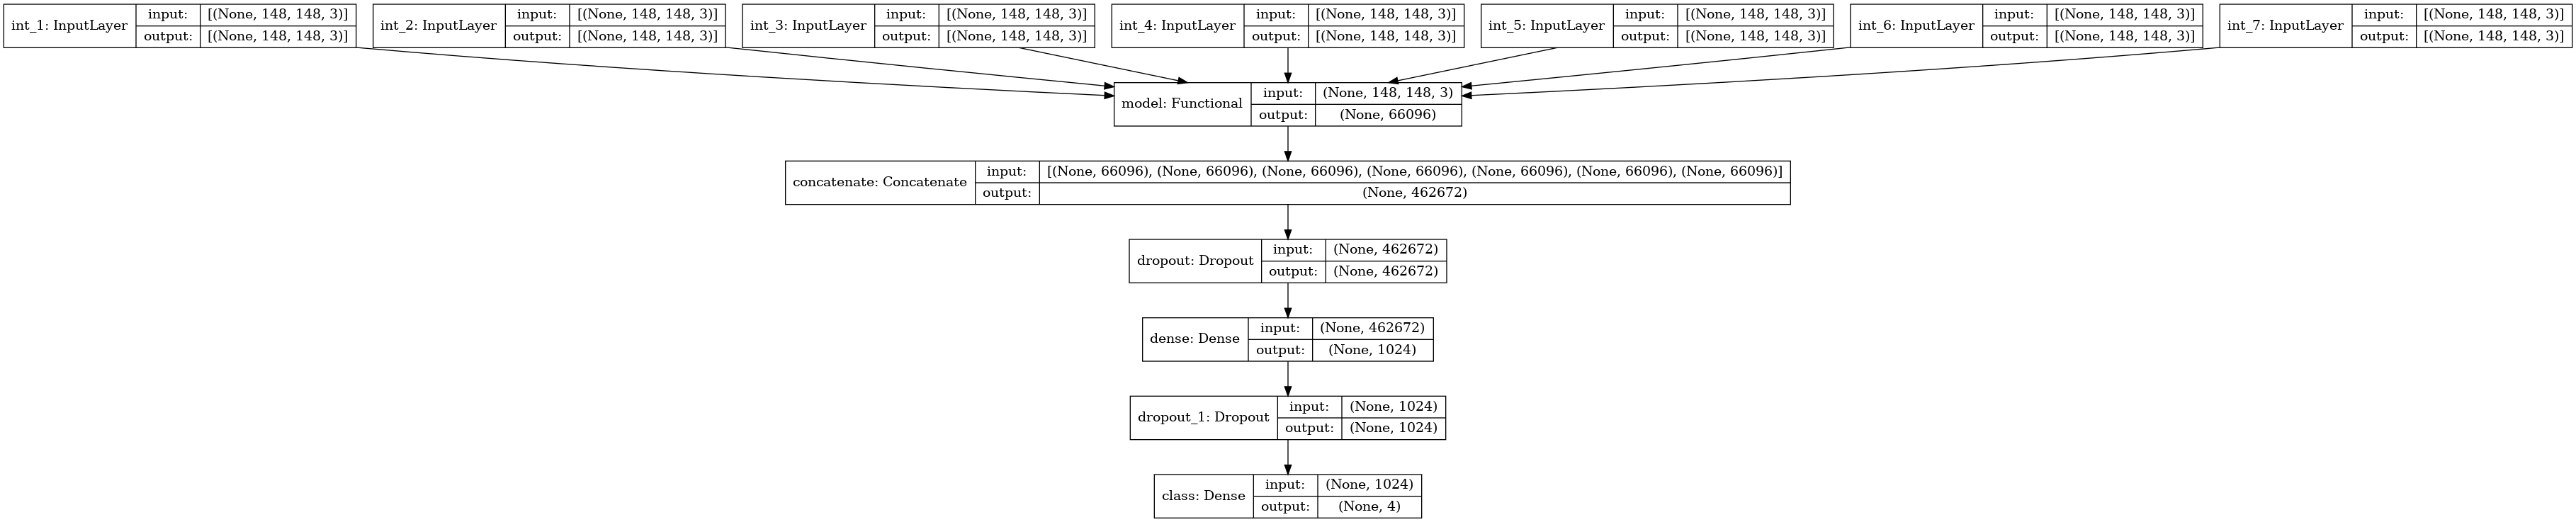

In [14]:
def get_model1():
    img_shape = (148,148,3)
    base = base_model
    models = [base]*7
    input1 = Input(shape=img_shape,name="int_1")
    input2 = Input(shape=img_shape,name="int_2")
    input3 = Input(shape=img_shape,name="int_3")
    input4 = Input(shape=img_shape,name="int_4")
    input5 = Input(shape=img_shape,name="int_5")
    input6 = Input(shape=img_shape,name="int_6")
    input7 = Input(shape=img_shape,name="int_7")
    
    inputs=[input1,input2,input3,input4,input5,input6,input7]
    
    ys=[models[i](inputs[i]) for i in range(len(inputs))]
    outputs =  tf.keras.layers.concatenate(ys,axis=-1)
    outputs = Dropout(0.4)(outputs)
    dense1 =  Dense(1024)(outputs)
    dense1 =  Dropout(0.3)(dense1)

    # SOFTMAX layer
    fina_out=Dense(4,activation="softmax",name="class")(dense1)

    model =Model(inputs=inputs, outputs=fina_out)
    
    return model
model = get_model1()
plot_model(model,show_shapes=True)

In [15]:
model = get_model1()
weight_dir = "/media/kashraf/Elements/Dissertation/modelling/General/weights/"            
checkpoint = ModelCheckpoint(os.path.join(weight_dir,"Multi_input_CNN_alpha_v1.h5"),
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr,earlystop]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adagrad(),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(train_gen,validation_data=test_gen,
    epochs=100,callbacks=callbacks
)

2022-12-08 11:18:28.265339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-08 11:18:28.302736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/100


2022-12-08 11:18:31.342986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-08 11:18:34.065874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1925/1925 [==============================] - 3846s 2s/step - loss: 21.1918 - accuracy: 0.6492 - val_loss: 6.9764 - val_accuracy: 0.8215

Epoch 00001: val_loss improved from inf to 6.97637, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/Multi_input_CNN_alpha_v1.h5
Epoch 2/100
1925/1925 [==============================] - 712s 370ms/step - loss: 3.3770 - accuracy: 0.8954 - val_loss: 3.2019 - val_accuracy: 0.9033

Epoch 00002: val_loss improved from 6.97637 to 3.20190, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/Multi_input_CNN_alpha_v1.h5
Epoch 3/100
1925/1925 [==============================] - 706s 367ms/step - loss: 1.8718 - accuracy: 0.9370 - val_loss: 2.4183 - val_accuracy: 0.9250

Epoch 00003: val_loss improved from 3.20190 to 2.41834, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/Multi_input_CNN_alpha_v1.h5
Epoch 4/100
1925/1925 [==============================] - 727s 378ms/step - los

1925/1925 [==============================] - 703s 365ms/step - loss: 0.5049 - accuracy: 0.9971 - val_loss: 1.4260 - val_accuracy: 0.9603

Epoch 00031: val_loss did not improve from 1.38868
Epoch 32/100
1925/1925 [==============================] - 703s 365ms/step - loss: 0.5257 - accuracy: 0.9945 - val_loss: 1.3630 - val_accuracy: 0.9582

Epoch 00032: val_loss improved from 1.38868 to 1.36297, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/Multi_input_CNN_alpha_v1.h5
Epoch 33/100
1925/1925 [==============================] - 703s 365ms/step - loss: 0.5034 - accuracy: 0.9966 - val_loss: 1.4208 - val_accuracy: 0.9586

Epoch 00033: val_loss did not improve from 1.36297
Epoch 34/100
1925/1925 [==============================] - 704s 366ms/step - loss: 0.5160 - accuracy: 0.9959 - val_loss: 1.4238 - val_accuracy: 0.9589

Epoch 00034: val_loss did not improve from 1.36297
Epoch 35/100
1925/1925 [==============================] - 703s 365ms/step - loss: 0.5325 - ac

In [21]:
import pickle
result_path = "/media/kashraf/Elements/Dissertation/modelling/General/results/MIMO_CNN/alpha/"

pickle.dump(history.history, open(os.path.join(result_path,"history_MIMO_alpha.pkl"), 'wb'))
history = history.history

### Loss curves

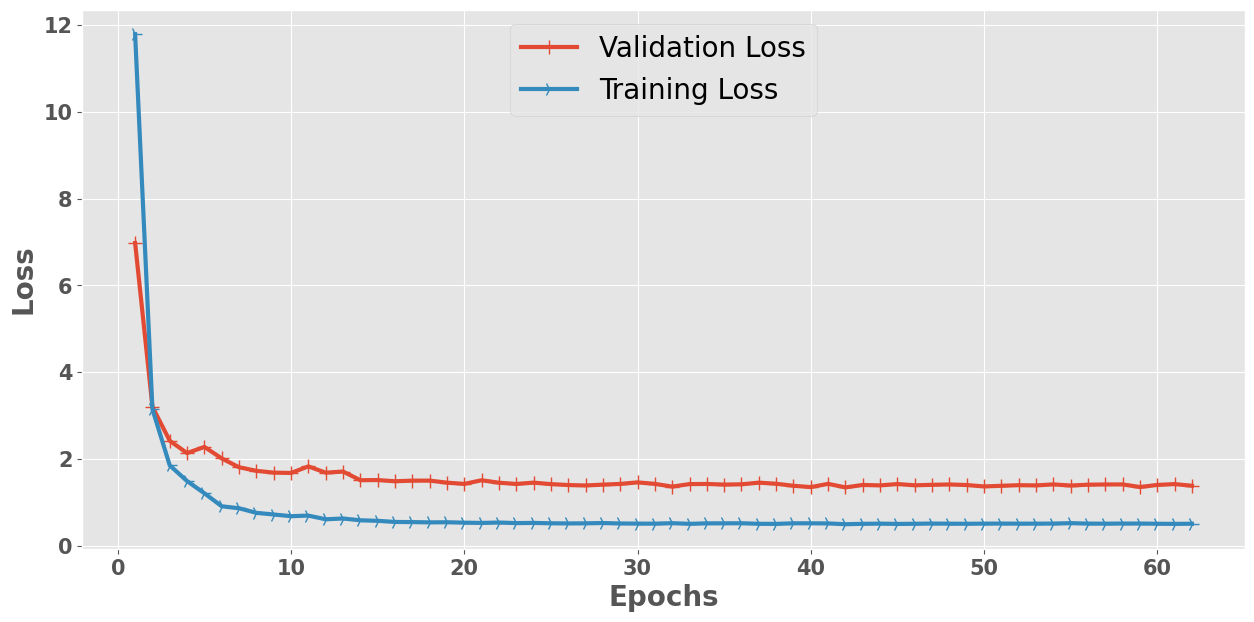

In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
loss_values = history['loss']
val_loss_values = history['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc = "upper center")
plt.savefig(result_path+'MIMO_alpha_Loss.png',bbox_inches ="tight",pad_inches =0)
plt.show()


## Accuracy curves

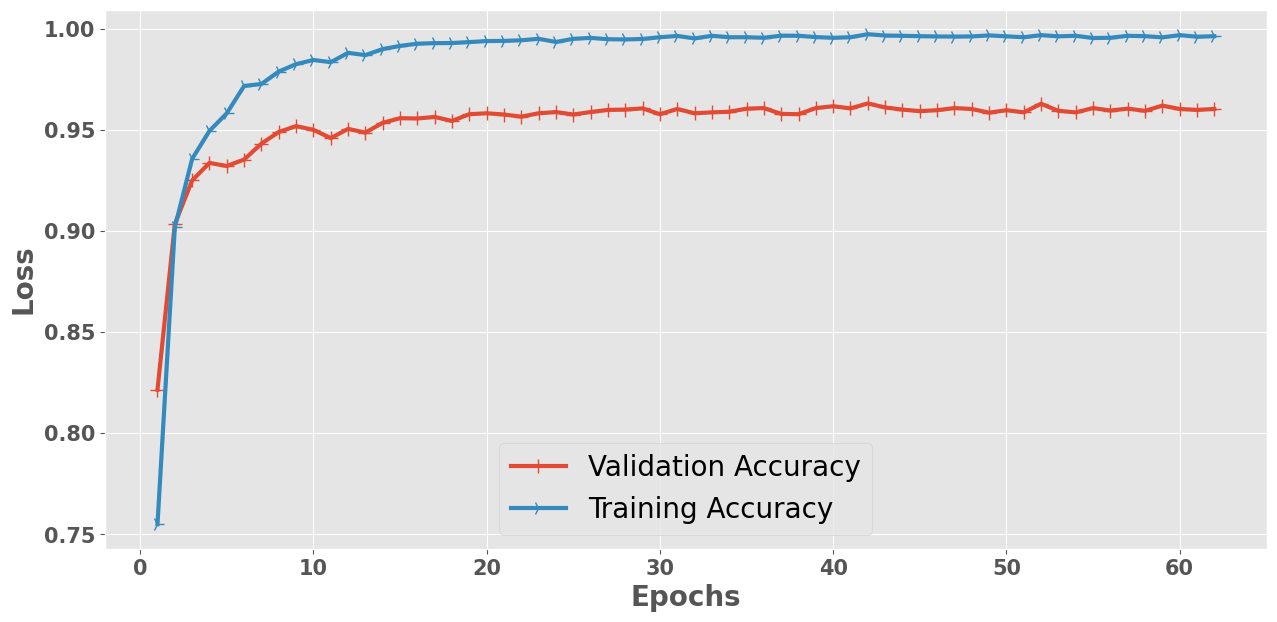

In [23]:
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values , label='Training Accuracy')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc= "lower center")
plt.savefig(result_path+'MIMO_alpha_Accuracy.png',bbox_inches ="tight",pad_inches =0)
plt.show()


## Confusion Matrix


 Classification report: 
               precision    recall  f1-score   support

        CL_1       0.96      0.96      0.96      1650
        CL_2       0.96      0.96      0.96      1650
        CL_3       0.97      0.96      0.97      1650
        CL_4       0.95      0.96      0.96      1650

    accuracy                           0.96      6600
   macro avg       0.96      0.96      0.96      6600
weighted avg       0.96      0.96      0.96      6600



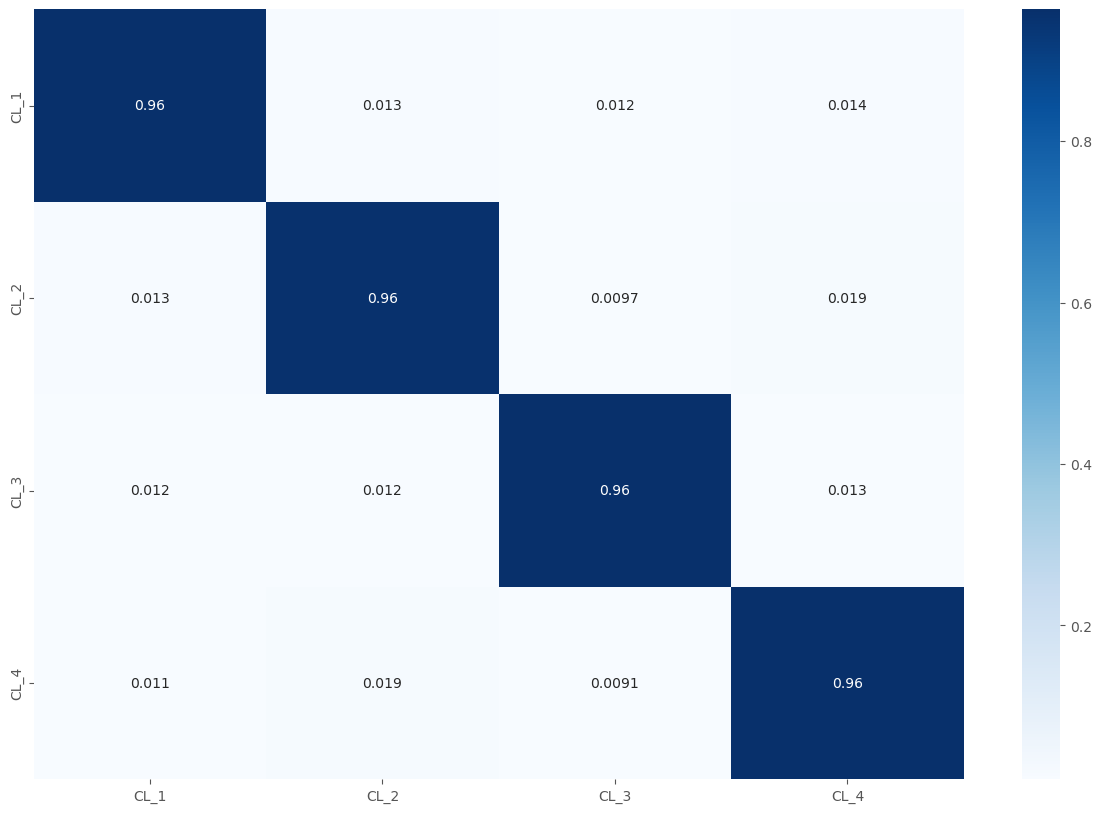

In [24]:
import seaborn as sr
import pandas as pd
test_gen  = CustomDataGen(x_test_files,y_test_files,batch_size=8,shuffle=False)
y_pred= np.argmax(model.predict(test_gen), axis=1)
y_test= test_gen.y_fnames

plt.style.use("ggplot")
# y_predict,distances1=  face_recognition(x_test_recog,T_distance)
# accuracy=accuracy_score(y_test_recog,y_predict)
class_names=["CL_1","CL_2","CL_3","CL_4"]
report=classification_report(y_test,y_pred,target_names=class_names)
np.save(result_path+"MIMO_theta_report.npy",report)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
plt.savefig(result_path+"MIMO_alpha_conf_mat.png")
plt.show()